# SHA-256 Implementation Using Concrete

In this tutorial, we will explore the implementation of SHA-256, a widely used hashing algorithm, using concrete-python. Details about the algorithm can be found [here](https://en.wikipedia.org/wiki/SHA-2).


In [1]:
# Uncomment this line to install dependency
# ! pip install concrete-python

# Required libraries
from concrete import fhe
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Data Representation
As mentioned in the wiki page, all variables are $32$-bit unsigned integers. Additions should be calculated modulo $2^{32}$.

While addition of 32-bit numbers are possible in the library, any other operations such modulizing, rotations, and bitwise operations are currently not possible. These operations require a lookup table with 32-bit inputs, but as of writing this tutorial, concrete-python supports up to 16-bit lookup tables. Higher precision lookup tables is still a research challenge in the homomorphic world and such a table would be dificult to compile and store at this moment.

Thus, we need to break all the variables to **chunks** and work at the chunk level. Throughtout the code, *WIDTH* refers to the bitwidth of a chunk, and *NUM_CHUNKS* shows the number of chunks we need to represent a 32-bit data. These parameters are set at the begining of the code. We vary these parameters to see the impact of the *WIDTH* on the performance of the compiler and the circuit.

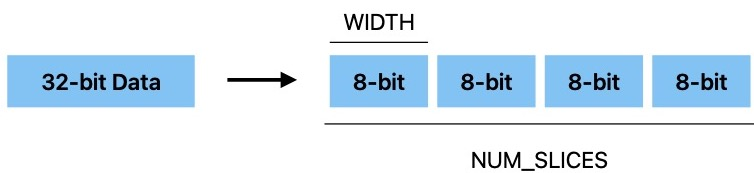

Figure 1: Shows a break down of 32 bit of data into 4 chunks of 8 bit. This is not the only way to chunk the input.

In [2]:
# Bitwidth of each chunk and number of chunks in each 32-bit number.
WIDTH, NUM_CHUNKS = 4, 8

## Some other valid parameter sets
# WIDTH, NUM_CHUNKS= 8, 4
# WIDTH, NUM_CHUNKS= 2, 16

assert WIDTH * NUM_CHUNKS == 32


def break_down_data(data, data_size):
    all_chunks = [
        [(x >> i * WIDTH) % (2**WIDTH) for i in range(data_size // WIDTH)[::-1]] for x in data
    ]
    return all_chunks


def reshape_data(data):
    return np.array(data).reshape(-1, NUM_CHUNKS)


def chunks_to_uint32(chunks):
    return int(sum([2 ** ((NUM_CHUNKS - 1 - i) * WIDTH) * x for i, x in enumerate(chunks)]))


def chunks_to_hexarray(chunks):
    hexes = [hex(chunks_to_uint32(word))[2:] for word in chunks]
    hexes = [
        "0" * (8 - len(y)) + y for y in hexes
    ]  # Appending leadning zero to the ones that are less than 8 characters TODO: write better
    result = "".join(hexes)
    return result

### Creating Chunks
There are two list of constants in the algorithm, K and H. Before executing the algorithm, we need to break them to chunks using `split_to_chunks` function.


The input of the algorithm is arbitrary bytes. We might need to break each byte to smaller chunks based on the value of *WIDTH* after padding the data as per instructed by the algorithm. `break_down_data` function returns a numpy array of shape (48,NUM_CHUNKS)

## Operations
Now that the data is stores as chunks, we must modify all operations we need to work at the level of chunks. In this section we explain how we implemented the required operations. The main three category of operations that we need to implement SHA-256 are:

*   Bitwise operations (AND, OR, XOR, NEGATE)
*   Shifts and Rotations
*   Modular Addition 

### Bitwise Operations
Bitwise operations are easily implemented in concrete-numpy. A bitwise operation over a 32-bit number is equivalent to the same operation over the chunks.

### Rotation and Shifts
To understand how rotations work, consider a small example with 4 chunks of width 4, representing a 16-bit number, as shown in Figure 1. Most significant bits are located at index 0. So a 16-bit number will be `[[chunk_0], [chunk_1], [chunk_2], [chunk_3]]` with WIDTH=4. There are two possible scenario for rotations:

1. Any rotation by a multiple of WIDTH (in this case, 4) will result in rotating the array of chunks. For example, right rotate(4) will be `[[chunk_3], [chunk_0], [chunk_1], [chunk_2]]`.

2. For rotations less than WIDTH, for example `y`, we break every chunk into two parts of bitlength, `WIDTH-y` and `y`. We need to add the low `y`-bits of each chunk with the high `WIDTH-y` bits of the next chunk. Figure 2 illustrated this process. We leverage two lookup tables to extract the two segments of each chunk.
<!-- `table_extract_low_bits_and_raise` extracts the low `y`-bits of each chunk and places them in the MSB of the chunk. `table_extract_high_bits` extracts WIDTH-y most significant bits of each chunk. -->

3. Rotations by other amounts are broken into the two steps described above.

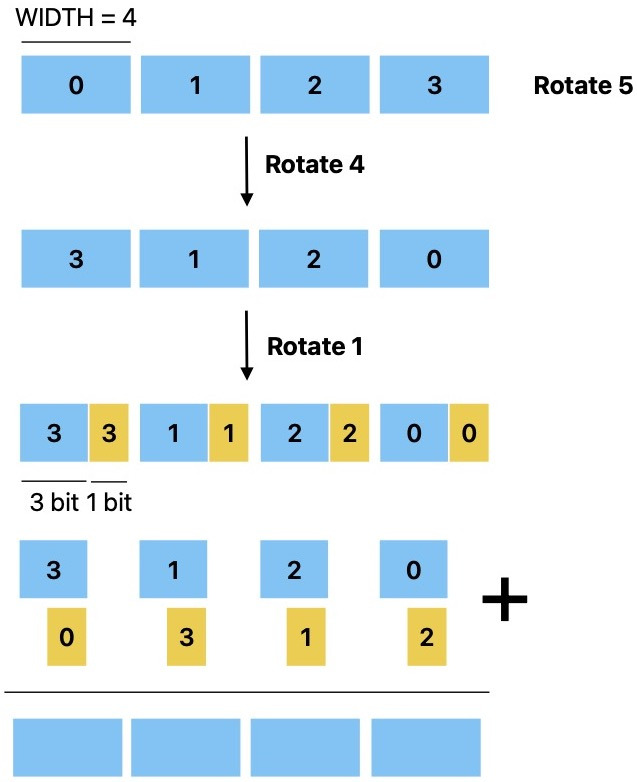

### Shift
The shift operation is the same as rotation, but we prepend the encrypted scalar zero when we move the bits to the right.

In [3]:
def right_rotate_list_of_chunks(list_to_rotate, amount):
    return np.concatenate((list_to_rotate[-amount:], list_to_rotate[:-amount]))


def right_shift_list_of_chunks(list_to_rotate, amount):
    return np.concatenate(([0] * list_to_rotate[-amount:].shape[0], list_to_rotate[:-amount]))


def left_shift_list_of_chunks(list_to_rotate, amount):
    return np.concatenate((list_to_rotate[amount:], [0] * list_to_rotate[:amount].shape[0]))


def rotate_less_than_width(chunks, shift):
    raised_low_bits = fhe.univariate(lambda x: (x % 2**shift) << (WIDTH - shift))(chunks)
    shifted_raised_low_bits = right_rotate_list_of_chunks(raised_low_bits, 1)

    high_bits = chunks >> shift
    return shifted_raised_low_bits + high_bits


def right_rotate(chunks, rotate_amount):
    x = rotate_amount // WIDTH
    y = rotate_amount % WIDTH
    rotated_chunks = right_rotate_list_of_chunks(chunks, x) if x != 0 else chunks
    rotated = rotate_less_than_width(rotated_chunks, y) if y != 0 else rotated_chunks

    return rotated


def right_shift(chunks, shift_amount):
    x = shift_amount // WIDTH
    y = shift_amount % WIDTH
    shifted_chunks = right_shift_list_of_chunks(chunks, x) if x != 0 else chunks

    if y != 0:
        # shift within chunks
        raised_low_bits = fhe.univariate(lambda x: (x % 2**y) << (WIDTH - y))(shifted_chunks)
        shifted_raised_low_bits = right_shift_list_of_chunks(raised_low_bits, 1)
        high_bits = shifted_chunks >> y
        result = shifted_raised_low_bits + high_bits
    else:
        result = shifted_chunks
    return result

### Modular 32-bit Addition
Modular 32-bit addition is frequently used in SHA256. While Concrete supports additions of 32-bit numbers, modulizing the result requires a lookup table which is too large for Concrete. Hence, the addition must be done over chunks.

Below is the function to add two 32-bit numbers mod $2^{32}$.

In [4]:
def add_two_32_bits(a, b):
    added = np.sum([a, b], axis=0)

    for i in range(NUM_CHUNKS):
        results = added % (2**WIDTH)
        if i < NUM_CHUNKS - 1:
            carries = added >> WIDTH
            added = left_shift_list_of_chunks(carries, 1) + results

    return results

In [5]:
# Testing the addition function, adding four 32-bit numbers
test_inputs = np.random.randint(0, 2**32, size=(2,))
input_chunks = break_down_data(test_inputs, 32)

assert chunks_to_uint32(add_two_32_bits(input_chunks[0], input_chunks[1])) == np.sum(
    test_inputs
) % (2**32)

Adding two 4-bit numbers results in a 5-bit number. We then use two lookup tables:

*   `extract_carry` which extracts the carry of adding two chunks
*   `extract_result` which extracts the 4-bit chunk which results from adding two chunks (without the carry)

Each carry must now be added to the chunk next chunk and this process is repeated for as many chunks as there are. The figure below illustrates this process.

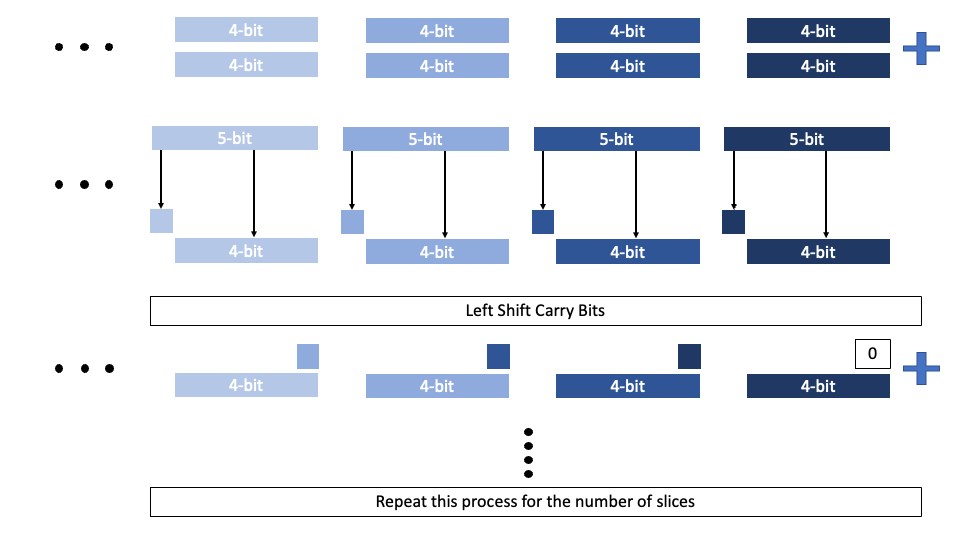



The benefit of this addition algorithm is that it can be extended to the case where more two 32-bit numbers are added. The only difference is that the carry from the first iteration of the loop can be larger than 1. Specifically, by adding $k$ 4-bit numbers, the carry can be as big as $\log_2 k$. For correctness, $\log_2 k$ must be less than 4 or $k<16$.

In our implementation of SHA-256, we only have two input and four input additions, so we only implement those.

For four input addition, he first iteration of the loop, we use a different lookup table that extract a 2-bit carry and rest of the chunk. The rest of the algorithm does not change.

In [6]:
def add_four_32_bits(a, b, c, d):
    added = np.sum([a, b, c, d], axis=0)

    # First iteration of the loop is seperated
    carries = added >> WIDTH
    results = added % (2**WIDTH)
    shifted_carries = left_shift_list_of_chunks(carries, 1)
    added = shifted_carries + results

    for i in range(1, NUM_CHUNKS):
        results = added % (2**WIDTH)

        # In the last iteration, carries need not be calculated
        if i != NUM_CHUNKS - 1:
            carries = added >> WIDTH
            shifted_carries = left_shift_list_of_chunks(carries, 1)
            added = shifted_carries + results

    return results

In [7]:
# Testing the addition function, adding four 32-bit numbers

for _ in range(1000):
    test_inputs = np.random.randint(0, 2**32, size=(4,))
    input_chunks = break_down_data(test_inputs, 32)

    assert chunks_to_uint32(
        add_four_32_bits(input_chunks[0], input_chunks[1], input_chunks[2], input_chunks[3])
    ) == np.sum(test_inputs) % (2**32)

## Operations for SHA-256

Using the basic operations from the previous section, we can now implement all the necessary functions for SHA256

In [8]:
# Used in the expansion


def s0(w):
    return right_rotate(w, 7) ^ right_rotate(w, 18) ^ right_shift(w, 3)


def s1(w):
    return right_rotate(w, 17) ^ right_rotate(w, 19) ^ right_shift(w, 10)


# Used in main loop


def S0(a_word):  # noqa: N802
    return right_rotate(a_word, 2) ^ right_rotate(a_word, 13) ^ right_rotate(a_word, 22)


def S1(e_word):  # noqa: N802
    return right_rotate(e_word, 6) ^ right_rotate(e_word, 11) ^ right_rotate(e_word, 25)


def Ch(e_word, f_word, g_word):  # noqa: N802
    return (e_word & f_word) ^ ((2**WIDTH - 1 - e_word) & g_word)


def Maj(a_word, b_word, c_word):  # noqa: N802
    return (a_word & b_word) ^ (a_word & c_word) ^ (b_word & c_word)


def main_loop(args, w_i_plus_k_i):
    a, b, c, d, e, f, g, h = args
    temp1 = add_four_32_bits(h, S1(e), Ch(e, f, g), w_i_plus_k_i)
    temp2 = add_two_32_bits(S0(a), Maj(a, b, c))
    new_a = add_two_32_bits(temp1, temp2)
    new_e = add_two_32_bits(d, temp1)
    return np.array([new_a, a, b, c, new_e, e, f, g])

We also need a function to pad the input as the first step of SHA256.

Moreover, we need a function to parse the input given to the program. The input is given as bytes, but the chunks might be smaller. We extract smaller chunks from bytes using lookup tables.

## Bringing it all together
Using all the components from the above, we can implement SHA256 as shown below.

In [9]:
K = [
    0x428A2F98,
    0x71374491,
    0xB5C0FBCF,
    0xE9B5DBA5,
    0x3956C25B,
    0x59F111F1,
    0x923F82A4,
    0xAB1C5ED5,
    0xD807AA98,
    0x12835B01,
    0x243185BE,
    0x550C7DC3,
    0x72BE5D74,
    0x80DEB1FE,
    0x9BDC06A7,
    0xC19BF174,
    0xE49B69C1,
    0xEFBE4786,
    0x0FC19DC6,
    0x240CA1CC,
    0x2DE92C6F,
    0x4A7484AA,
    0x5CB0A9DC,
    0x76F988DA,
    0x983E5152,
    0xA831C66D,
    0xB00327C8,
    0xBF597FC7,
    0xC6E00BF3,
    0xD5A79147,
    0x06CA6351,
    0x14292967,
    0x27B70A85,
    0x2E1B2138,
    0x4D2C6DFC,
    0x53380D13,
    0x650A7354,
    0x766A0ABB,
    0x81C2C92E,
    0x92722C85,
    0xA2BFE8A1,
    0xA81A664B,
    0xC24B8B70,
    0xC76C51A3,
    0xD192E819,
    0xD6990624,
    0xF40E3585,
    0x106AA070,
    0x19A4C116,
    0x1E376C08,
    0x2748774C,
    0x34B0BCB5,
    0x391C0CB3,
    0x4ED8AA4A,
    0x5B9CCA4F,
    0x682E6FF3,
    0x748F82EE,
    0x78A5636F,
    0x84C87814,
    0x8CC70208,
    0x90BEFFFA,
    0xA4506CEB,
    0xBEF9A3F7,
    0xC67178F2,
]
H = [0x6A09E667, 0xBB67AE85, 0x3C6EF372, 0xA54FF53A, 0x510E527F, 0x9B05688C, 0x1F83D9AB, 0x5BE0CD19]

In [10]:
k_in = reshape_data(break_down_data(K, 32))
h_in = reshape_data(break_down_data(H, 32))

In [11]:
def uint64_to_bin(uint64: int):
    return "".join([str(uint64 >> i & 1) for i in range(63, -1, -1)])


def sha256_preprocess(text):
    """
    Takes a message of arbitrary length and returns a message
    of length that is a multiple of 512 bits, with the original message padded
    with a 1 bit, followed by 0 bits, followed by the original message length
    in bits
    """
    data = text
    # convert to uint4 and group into 32 bit words (8 uint4s)
    # #log ("data is:", data, data.shape)
    message_len = data.shape[0] * 8  # denoted as 'l' in spec
    # find padding length 'k'
    k = (((448 - 1 - message_len) % 512) + 512) % 512
    # #log ("k is:", k)
    zero_pad_width_in_bits = k
    padstring = "1" + "0" * zero_pad_width_in_bits + str(uint64_to_bin(message_len))
    # log ("padstring size:", len(padstring))
    # log ("padstring is:", padstring)

    total_size = len(padstring) + message_len
    # log ("total size:", total_size)
    assert total_size % 512 == 0

    pad = np.array(
        [int(padstring[i : i + 8], 2) for i in range(0, len(padstring), 8)], dtype=np.uint8
    )
    padded = np.concatenate((data, pad))
    words = break_down_data(padded, 8)
    chunks = reshape_data(words)
    return chunks

In [12]:
# Number of rounds must be 64 to have correct SHA256
# If looking to get a faster run, reduce the number of rounds (but it will not be correct)


def sha256(data, number_of_rounds=64):
    h_chunks = fhe.zeros((len(h_in), NUM_CHUNKS))
    k_chunks = fhe.zeros((len(k_in), NUM_CHUNKS))
    h_chunks += h_in
    k_chunks += k_in

    num_of_iters = data.shape[0] * 32 // 512
    for chunk_iter in range(0, num_of_iters):

        # Initializing the variables
        chunk = data[chunk_iter * 16 : (chunk_iter + 1) * 16]
        w = [None for _ in range(number_of_rounds)]
        # Starting the main loop and expansion
        working_vars = h_chunks
        for j in range(0, number_of_rounds):
            if j < 16:
                w[j] = chunk[j]
            else:
                w[j] = add_four_32_bits(w[j - 16], s0(w[j - 15]), w[j - 7], s1(w[j - 2]))
            w_i_k_i = add_two_32_bits(w[j], k_chunks[j])
            working_vars = main_loop(working_vars, w_i_k_i)

        # Accumulating the results
        for j in range(8):
            h_chunks[j] = add_two_32_bits(h_chunks[j], working_vars[j])
    return h_chunks

We can test the correctness of this function as below (this is not in encrypted form yet)

In [13]:
import hashlib

text = (
    b"Lorem ipsum dolor sit amet, consectetur adipiscing elit. "
    b"Curabitur bibendum, urna eu bibendum egestas, neque augue eleifend odio, "
    b"et sagittis viverra. and more than 150"
)

result = sha256(sha256_preprocess(np.frombuffer(text, dtype=np.uint8)))

m = hashlib.sha256()
m.update(text)

print("    SHA256:", m.hexdigest())
print("Our SHA256:", chunks_to_hexarray(result))
print("Match:", chunks_to_hexarray(result) == m.hexdigest())

    SHA256: a412c46b0be134c593b0ad520d4a4c4e1d8aecca799be0be2c4d233ccf455cb7
Our SHA256: a412c46b0be134c593b0ad520d4a4c4e1d8aecca799be0be2c4d233ccf455cb7
Match: True


In [14]:
class HomomorphicSHA:  # noqa: N802
    circuit: fhe.Circuit

    def __init__(self, input_size_in_bytes=150, number_of_rounds=64) -> None:
        self.input_size_in_bytes = input_size_in_bytes
        assert 0 <= number_of_rounds <= 64, "Number of rounds must be betweem zero and 64"
        self.number_of_rounds = number_of_rounds
        inputset = [
            sha256_preprocess(np.random.randint(0, 2**8, size=(input_size_in_bytes,)))
            for _ in range(100)
        ]
        # Compilation of the circuit should take a few minutes
        compiler = fhe.Compiler(
            lambda data: sha256(data, self.number_of_rounds), {"data": "encrypted"}
        )
        self.circuit = compiler.compile(
            inputset=inputset,
            configuration=fhe.Configuration(
                enable_unsafe_features=True,
                use_insecure_key_cache=True,
                insecure_key_cache_location=".keys",
                dataflow_parallelize=True,
            ),
            verbose=False,
        )

    def getSHA(self, data):  # noqa: N802
        assert (
            len(data) == self.input_size_in_bytes
        ), f"Input size is not correct, should be {self.input_size_in_bytes} bytes/characters"
        return self.circuit.encrypt_run_decrypt(sha256_preprocess(data))

    def getPlainSHA(self, data):  # noqa: N802
        return sha256(sha256_preprocess(data), self.number_of_rounds)

Now we are ready to compile the circuit! Note that **the compilation will take a long time**, so if you are looking to get a test run, you can set the number of rounds to something smaller than 64.

In [15]:
# Warning: This will compile the circuit and will take a few minutes

input_size_in_bytes = 150
running_small_example = True

if running_small_example:
    number_of_rounds = 2
    sha = HomomorphicSHA(input_size_in_bytes, number_of_rounds)
else:
    sha = HomomorphicSHA(input_size_in_bytes)

And after compilation, we are ready to run the circuit. Remember that the input size has to match what you gave in the previous cell. Our function will check this first to make sure the input is of the correct size. 

In [16]:
# WARNING: This takes a LONG time
accept_a_very_long_run = False
if not accept_a_very_long_run:
    print(
        "This cell is disabled. It can takes hours. If you want to run this "
        "cell, set accept_a_very_long_run=True"
    )
else:
    text = (
        b"Lorem ipsum dolor sit amet, consectetur adipiscing elit. "
        b"Curabitur bibendum, urna eu bibendum egestas, neque augue eleifend odio, "
        b"et sagittis viverra."
    )
    input_bytes = np.frombuffer(text, dtype=np.uint8)
    encrypted_evaluation = sha.getSHA(input_bytes)

    print("Encrypted Evaluation: ", chunks_to_hexarray(encrypted_evaluation))
    print("    Plain Evaluation: ", chunks_to_hexarray(sha.getPlainSHA(input_bytes)))

This cell is disabled. It can takes hours. If you want to run this cell, set accept_a_very_long_run=True
